## FILE CREATION

**GOAL**:
In this notebook we will create a **parquet** file (more efficient than csv) combining data from NO2 levels from all the months in the year 2018. We will also join two more tables containing info from the stations and info from the temperatures. We will also drop unnecesary features and handle missing data.

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from pathlib import Path

### Reading the csv we will use

In [67]:
path = '/home/carleondel/data-madrid_pollution_project/'

In [68]:
df_stations = pd.read_csv(path + 'madrid_air_quality_stations.csv')
df_temp = pd.read_csv(path + 'madrid_hourly_temperatures_2018.csv')

In [69]:
# Define a list of month names
months = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Create an empty dictionary to store DataFrames
monthly_dfs = {}

# Loop through the months and read corresponding CSV files
for month in months:
    file_path = path + f'{month}_mo18.csv'
    df_month = pd.read_csv(file_path, sep=';')
    # Store the DataFrame in the dictionary with the month name as the key
    monthly_dfs[month] = df_month


Now for every month, we:
1. Filter by NO2 levels (MAGNITUD = 8)  (and drop that column)
2. Change the 0 measurements (Not Valid measurements) into NaN
3. Convert the hour columns into rows
4. Create a date 'FECHA' column (and drop all the date related features)

In [70]:
filtered_monthly_dfs = {}

# List of columns starting with 'H'
H_cols = [f'H{i:02d}' for i in range(1, 25)]

# Loop through the months
for month in months:
    # Access the DataFrame for the current month
    df = monthly_dfs[month]
    
    # Filter the DataFrame to keep only NO2 levels
    df_NO2 = df[df['MAGNITUD'] == 8]
    
    # Drop the 'MAGNITUD' column
    df_NO2 = df_NO2.drop('MAGNITUD', axis=1)

    # Replace 0 values with NaN in the selected columns
    df_NO2[H_cols] = df_NO2[H_cols].replace(0, np.nan)

    # Melt to convert the hour columns into rows
    melted_df = pd.melt(df_NO2, id_vars=['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA'], value_vars=H_cols, var_name='HORA', value_name='NO2_level')

    # Create new column with the last 2 positions from HORA
    # Then we substract 1 and add half hour (this way we avoid trouble with hour 24)
    # and convert it to str
    melted_df['HORA_new'] = (melted_df['HORA'].astype(str).str[-2:].astype(int) - 1).astype(str) + ':30:00'

    # Combine 'ANO', 'MES', 'DIA', and 'HORA' columns to form the 'FECHA' column
    melted_df['FECHA'] = pd.to_datetime(melted_df[['ANO', 'MES', 'DIA']].astype(str).agg('-'.join, axis=1) + ' ' + melted_df['HORA_new'].astype(str), format='%Y-%m-%d %H:%M:%S')
    
    # Drop unnecessary columns
    melted_df = melted_df.drop(columns=['ANO', 'MES', 'DIA', 'HORA', 'HORA_new'])

    # Store the filtered DataFrame in the dictionary
    filtered_monthly_dfs[month] = melted_df

In [71]:
filtered_monthly_dfs['ene']

,PROVINCIA,MUNICIPIO,ESTACION,PUNTO_MUESTREO,NO2_level,FECHA
0,28,79,4,28079004_8_8,15.0,2018-01-01 00:30:00
1,28,79,4,28079004_8_8,13.0,2018-01-02 00:30:00
2,28,79,4,28079004_8_8,35.0,2018-01-03 00:30:00
3,28,79,4,28079004_8_8,35.0,2018-01-04 00:30:00
4,28,79,4,28079004_8_8,24.0,2018-01-05 00:30:00
...,...,...,...,...,...,...
17851,28,79,60,28079060_8_8,19.0,2018-01-27 23:30:00
17852,28,79,60,28079060_8_8,20.0,2018-01-28 23:30:00
17853,28,79,60,28079060_8_8,85.0,2018-01-29 23:30:00
17854,28,79,60,28079060_8_8,73.0,2018-01-30 23:30:00


Let's prepare our dfs containing info from temperature and stations to join them

In [72]:
df_temp.head()

,date,hour,temp
0,2018-01-01,0,7.3
1,2018-01-01,1,7.4
2,2018-01-01,2,6.8
3,2018-01-01,3,7.1
4,2018-01-01,4,5.3


In [73]:
# Combine 'date' and 'hour' columns and add '30:00'
df_temp['date'] = pd.to_datetime(df_temp['date'] + ' ' + df_temp['hour'].astype(str) + ':30:00', format='%Y-%m-%d %H:%M:%S')

# Drop the 'hour' column
df_temp = df_temp.drop(['hour'], axis=1)

In [74]:
df_temp.head()

,date,temp
0,2018-01-01 00:30:00,7.3
1,2018-01-01 01:30:00,7.4
2,2018-01-01 02:30:00,6.8
3,2018-01-01 03:30:00,7.1
4,2018-01-01 04:30:00,5.3


Now our temperatures dataframe is ready to be joined with our months using date as key

In [75]:
df_stations.head()

,station,area,name,address,altitude,type,longitude,latitude
0,28079004,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
1,28079008,centro,Escuelas Aguirre,Entre C/ Alcalá y C/ O' Donell,670,UT,-3.682319,40.421564
2,28079011,centro,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,708,UT,-3.677356,40.451475
3,28079016,noreste,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,693,UF,-3.639233,40.440047
4,28079017,suroeste,Villaverde,C/. Juan Peñalver,604,UF,-3.713322,40.347139


In [76]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    24 non-null     int64  
 1   area       24 non-null     object 
 2   name       24 non-null     object 
 3   address    24 non-null     object 
 4   altitude   24 non-null     int64  
 5   type       24 non-null     object 
 6   longitude  24 non-null     float64
 7   latitude   24 non-null     float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.6+ KB


To join this stations table, we need to modify first our monthly dataframes so 'PUNTO_MUESTREO' has the same format as 'station'

In [77]:
ready_monthly_dfs = {}


# Loop through the months
for month in months:
    # Access the DataFrame for the current month
    df = filtered_monthly_dfs[month]
    df['PUNTO_MUESTREO'] = (df['PUNTO_MUESTREO'].str[:-4]).astype(int)
    
    # Store the filtered DataFrame in the dictionary
    ready_monthly_dfs[month] = df

In [78]:
ready_monthly_dfs['ene'].head()

,PROVINCIA,MUNICIPIO,ESTACION,PUNTO_MUESTREO,NO2_level,FECHA
0,28,79,4,28079004,15.0,2018-01-01 00:30:00
1,28,79,4,28079004,13.0,2018-01-02 00:30:00
2,28,79,4,28079004,35.0,2018-01-03 00:30:00
3,28,79,4,28079004,35.0,2018-01-04 00:30:00
4,28,79,4,28079004,24.0,2018-01-05 00:30:00


### Everything is set to be joined
- First we will concat all our month tables
- Then we will left join our temp table based on 
- Final left join of our stations table

In [79]:
# Concatenate DataFrames
df_2018 = pd.concat(ready_monthly_dfs, ignore_index=True)


In [80]:
len(df_2018)

210000

In [81]:
merged_df = pd.merge(df_2018, df_temp, left_on='FECHA', right_on='date', how='left')
merged_df = merged_df.drop('date', axis=1)

In [82]:
merged_df.head()

,PROVINCIA,MUNICIPIO,ESTACION,PUNTO_MUESTREO,NO2_level,FECHA,temp
0,28,79,4,28079004,15.0,2018-01-01 00:30:00,7.3
1,28,79,4,28079004,13.0,2018-01-02 00:30:00,9.1
2,28,79,4,28079004,35.0,2018-01-03 00:30:00,7.5
3,28,79,4,28079004,35.0,2018-01-04 00:30:00,8.1
4,28,79,4,28079004,24.0,2018-01-05 00:30:00,9.7


In [83]:
df = pd.merge(merged_df, df_stations, left_on='PUNTO_MUESTREO', right_on='station', how='left')
df = df.drop('station', axis=1)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PROVINCIA       210000 non-null  int64         
 1   MUNICIPIO       210000 non-null  int64         
 2   ESTACION        210000 non-null  int64         
 3   PUNTO_MUESTREO  210000 non-null  int64         
 4   NO2_level       209676 non-null  float64       
 5   FECHA           210000 non-null  datetime64[ns]
 6   temp            210000 non-null  float64       
 7   area            210000 non-null  object        
 8   name            210000 non-null  object        
 9   address         210000 non-null  object        
 10  altitude        210000 non-null  int64         
 11  type            210000 non-null  object        
 12  longitude       210000 non-null  float64       
 13  latitude        210000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), in

In [85]:
df.isna().sum()

PROVINCIA           0
MUNICIPIO           0
ESTACION            0
PUNTO_MUESTREO      0
NO2_level         324
FECHA               0
temp                0
area                0
name                0
address             0
altitude            0
type                0
longitude           0
latitude            0
dtype: int64

In [86]:
df.nunique()

PROVINCIA            1
MUNICIPIO            1
ESTACION            24
PUNTO_MUESTREO      24
NO2_level          252
FECHA             8760
temp               438
area                 5
name                24
address             24
altitude            23
type                 3
longitude           24
latitude            24
dtype: int64

In [87]:
df.head()

,PROVINCIA,MUNICIPIO,ESTACION,PUNTO_MUESTREO,NO2_level,FECHA,temp,area,name,address,altitude,type,longitude,latitude
0,28,79,4,28079004,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
1,28,79,4,28079004,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
2,28,79,4,28079004,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
3,28,79,4,28079004,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
4,28,79,4,28079004,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853


### Dropping Features

Since we are only working with data from Madrid, we can drop the PROVINCIA, MUNICIPIO AND PUNTO_MUESTREO features. `PUNTO_MUESTREO` is a composite identifier combining the rest of the location features.

In [88]:
df = df.drop(columns=['PROVINCIA', 'MUNICIPIO', 'PUNTO_MUESTREO'], axis = 1)

And I'm guessing ESTACION contains a unique identifier for each station name / address, so we can keep only one of those without losing info

In [89]:
df.groupby('ESTACION')[['name', 'address']].nunique()

,name,address
ESTACION,,
4,1,1
8,1,1
11,1,1
16,1,1
17,1,1
18,1,1
24,1,1
27,1,1
35,1,1


In [90]:
# We will just keep the name
df = df.drop(columns=['ESTACION', 'address'], axis = 1)

In [91]:
df.head()

,NO2_level,FECHA,temp,area,name,altitude,type,longitude,latitude
0,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,635,UT,-3.712247,40.423853
1,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,635,UT,-3.712247,40.423853
2,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,635,UT,-3.712247,40.423853
3,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,635,UT,-3.712247,40.423853
4,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,635,UT,-3.712247,40.423853


### Handling missing data

In [92]:
df.isna().sum()

NO2_level    324
FECHA          0
temp           0
area           0
name           0
altitude       0
type           0
longitude      0
latitude       0
dtype: int64

Let's explore those missing values and their distribution

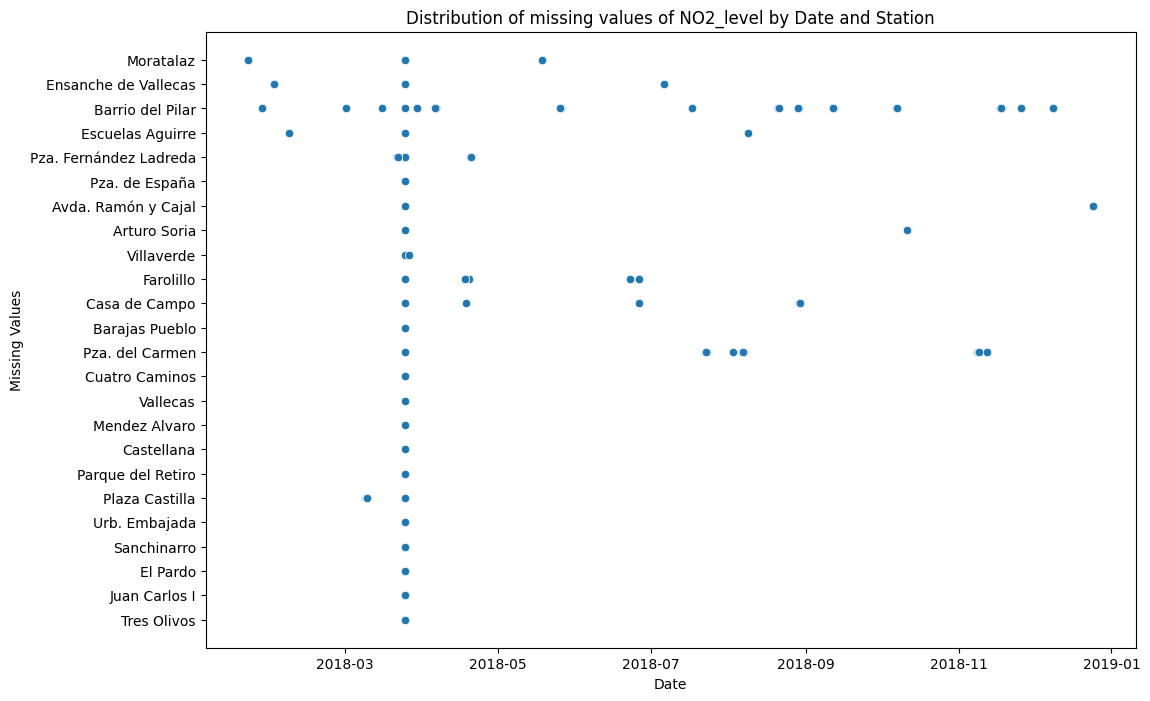

In [93]:
# Create new column indicating if 'NO2_level' is NaN
df['missing_values'] = df['NO2_level'].isna()

missing_values_df = df[df['missing_values']]

# Create scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='FECHA', y='name', data=missing_values_df)
plt.title('Distribution of missing values of NO2_level by Date and Station')
plt.xlabel('Date')
plt.ylabel('Missing Values')
plt.show()

It appears that there is a specific timestamp where no station recorded any data, so we should consider dropping that particular entry. Apart from this, the missing values seem to be randomly distributed and are limited to a few data points. For these instances, we plan to implement a time-based imputation method.

In [94]:
df.groupby(df['FECHA'].dt.date)['missing_values'].sum().idxmax()

datetime.date(2018, 3, 25)

In [95]:
df.groupby(df['FECHA'].dt.date)['missing_values'].sum().max()

24

What happened on March 25th? The time zone change!

In [96]:
df[(df['FECHA'].dt.date == pd.to_datetime('2018-03-25').date()) & (df['missing_values'] == True)]

,NO2_level,FECHA,temp,area,name,altitude,type,longitude,latitude,missing_values
35496,NaN,2018-03-25 02:30:00,7.0,centro,Pza. de España,635,UT,-3.712247,40.423853,True
35527,NaN,2018-03-25 02:30:00,7.0,centro,Escuelas Aguirre,670,UT,-3.682319,40.421564,True
35558,NaN,2018-03-25 02:30:00,7.0,centro,Avda. Ramón y Cajal,708,UT,-3.677356,40.451475,True
35589,NaN,2018-03-25 02:30:00,7.0,noreste,Arturo Soria,693,UF,-3.639233,40.440047,True
35620,NaN,2018-03-25 02:30:00,7.0,suroeste,Villaverde,604,UF,-3.713322,40.347139,True
35651,NaN,2018-03-25 02:30:00,7.0,suroeste,Farolillo,630,UF,-3.731853,40.394781,True
35682,NaN,2018-03-25 02:30:00,7.0,noroeste,Casa de Campo,642,S,-3.747347,40.419356,True
35713,NaN,2018-03-25 02:30:00,7.0,noreste,Barajas Pueblo,621,UF,-3.580031,40.476928,True
35744,NaN,2018-03-25 02:30:00,7.0,centro,Pza. del Carmen,659,UF,-3.703172,40.419208,True
35775,NaN,2018-03-25 02:30:00,7.0,sureste,Moratalaz,685,UT,-3.645306,40.407947,True


We have a data gap across all stations at 2:00 am, coinciding with the timezone adjustment. So we drop this hour.

In [97]:
df = df[df['FECHA'] != '2018-03-25 02:30:00']

Let's check again

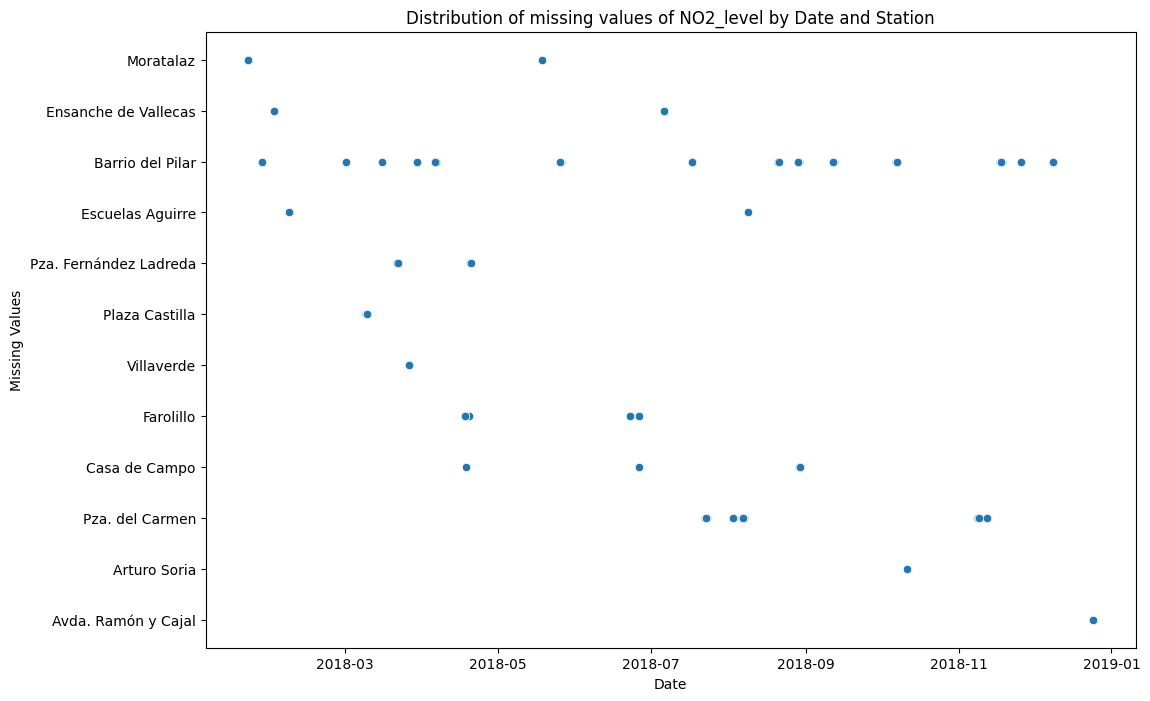

In [98]:
# Create new column indicating if 'NO2_level' is NaN
df['missing_values'] = df['NO2_level'].isna()

missing_values_df = df[df['missing_values']]

# Create scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='FECHA', y='name', data=missing_values_df)
plt.title('Distribution of missing values of NO2_level by Date and Station')
plt.xlabel('Date')
plt.ylabel('Missing Values')
plt.show()

We will imput these missing values based on the daily mean derived from all stations

In [99]:
daily_mean = df.groupby(df['FECHA'].dt.date)['NO2_level'].mean()
df['NO2_level'] = df['NO2_level'].fillna(df['FECHA'].dt.date.map(daily_mean))

In [100]:
df = df.drop(columns = 'missing_values', axis = 1)

In [101]:
df.isna().sum()

NO2_level    0
FECHA        0
temp         0
area         0
name         0
altitude     0
type         0
longitude    0
latitude     0
dtype: int64

## Clean Dataframe

In [102]:
df.head()

,NO2_level,FECHA,temp,area,name,altitude,type,longitude,latitude
0,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,635,UT,-3.712247,40.423853
1,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,635,UT,-3.712247,40.423853
2,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,635,UT,-3.712247,40.423853
3,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,635,UT,-3.712247,40.423853
4,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,635,UT,-3.712247,40.423853


We save our clean dataframe into a parquet file

In [103]:
df.to_parquet('clean_data.parquet', index=False)